# Further implementation 

This is the third part of the notebooks for the Natural Language Processing course, held by Prof. Carman, a.a. 2024/2025.

**Authors:**

Matteo Figini
Riccardo Figini
Samuele Forner
Caterina Motti
Simone Zacchetti

In this notebook we are going to implement the most advanded topic we have seen in the lesson and a bit more...

## Text-to-image

We would like to see how some of our riceipts can look like...

In [1]:
!pip install --upgrade --quiet langchain langchain-core langchain-openai
!pip install -q python-terrier==0.11.0
!pip install --upgrade langgraph

In [2]:
import os
import pandas as pd
import torch
import matplotlib.pyplot as plt
from huggingface_hub import login
from kaggle_secrets import UserSecretsClient
from diffusers import DiffusionPipeline

2025-05-21 20:36:05.168123: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747859765.190038     259 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747859765.196828     259 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnableSequence
from langchain.output_parsers import ResponseSchema, StructuredOutputParser
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
import pandas as pd
import pyterrier as pt
import json
import openai
from langchain_core.messages import HumanMessage
from typing import Any
from typing import Annotated, Literal
from typing_extensions import TypedDict
from langchain.output_parsers import StructuredOutputParser, ResponseSchema
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
from langchain_core.messages import AIMessage
from langchain_openai import ChatOpenAI
from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import AnyMessage, add_messages
from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda, RunnableWithFallbacks
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate

In [4]:
user_secrets = UserSecretsClient()

# HuggingFace login token
secret_value_0 = user_secrets.get_secret("NLP project")

# OpenAI API key
secret_value_1 = user_secrets.get_secret("OPENAI_API_KEY")

# Log-in in Huggingface
login(secret_value_0)

In [5]:
# save OpenAI key
openai.api_key = secret_value_1

In [6]:
df = pd.read_csv('/kaggle/input/recipe-sampled-0-25/sampled_dataset.csv')
df = df.rename(columns={'Unnamed: 0': 'id'})

In [7]:
# Extract 3 titles to turn into images
sampled_titles = df['title'].sample(n=3, random_state=42).tolist()

In [8]:
pipe = DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16, use_safetensors=True, variant="fp16")
pipe.to("cuda")

'pipe = DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16, use_safetensors=True, variant="fp16")\npipe.to("cuda")'

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, title in enumerate(sampled_titles):
    image = pipe(prompt=title).images[0]
    axes[i].imshow(image)
    axes[i].set_title(title, fontsize=10)
    axes[i].axis('off')

"fig, axes = plt.subplots(1, 3, figsize=(15, 5))\nfor i, title in enumerate(sampled_titles):\n    image = pipe(prompt=title).images[0]\n    axes[i].imshow(image)\n    axes[i].set_title(title, fontsize=10)\n    axes[i].axis('off')"

## Multi agent system using Pretrained LLM

This code implements a multi-agent system for generating and refining cooking recipes using a pretrained LLM (GPT-4) and information retrieval techniques. It leverages PyTerrier for indexing and retrieving recipes based on ingredients and directions. The system allows dynamic interactions with the user, enabling recipe generation, modification, and regeneration based on feedback. Using LangChain and LangGraph, the system orchestrates a workflow of nodes for handling user input, generating recipes, and refining them based on real-time corrections. The approach integrates both tools and prompts to create a flexible, user-driven cooking assistant.

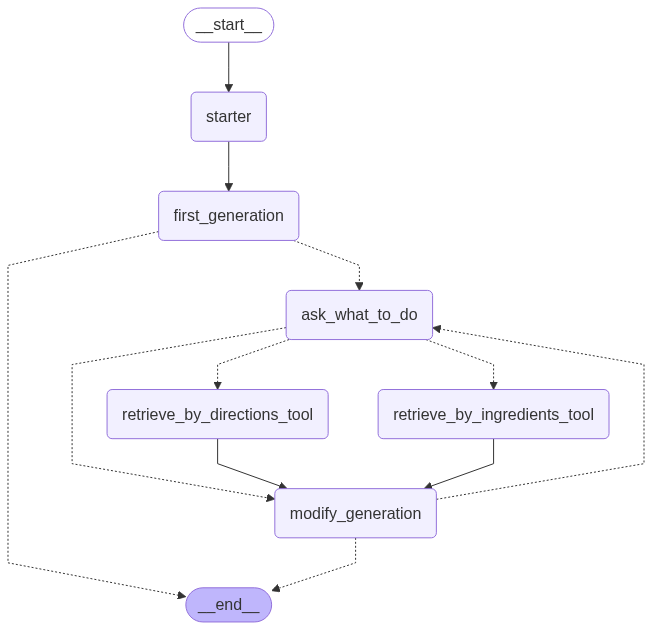

In [39]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [ ]:
if not pt.started():
    pt.init()

### Graph objects

In [11]:
"""
I am using the ChatOpenAI model from LangChain, which is a wrapper around OpenAI's GPT-3.5 and GPT-4 models.
"""
llm = ChatOpenAI(model="gpt-4", temperature=0.7, openai_api_key=secret_value_1)

In [12]:
"""
State Graph, maintaining the state of the conversation.
"""
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

### RAG

In [13]:
# Percorso assoluto all'indice
index_path = "/kaggle/working/t"

# Verifica se l'indice esiste già
if os.path.exists(index_path) and os.path.exists(os.path.join(index_path, "data.properties")):
    print("✔️ Index already exists. Using existing index.")
    indexref = index_path
else:
    print("🛠️ Index not found. Building new index...")

    documents_fields = [
        {
            'docno': str(row['id']),  # usa l'id reale
            'title': row['title'],
            'ingredients': row['ingredients'],
        }
        for _, row in df.iterrows()
    ]

    os.makedirs(index_path, exist_ok=True)

    indexer_fields = pt.IterDictIndexer(index_path)
    indexref = indexer_fields.index(
        documents_fields,
        fields=["title", "ingredients"],
        meta={'docno': 20, 'title': 512, 'ingredients': 1024}
    )

# Costruisci oggetto Index e motore di retrieval
index_fields = pt.IndexFactory.of(indexref)
bm25_ingredients = pt.terrier.Retriever(
    index_fields,
    wmodel="BM25",
    controls={"w": "1.0"},
    metadata=["docno", "ingredients"],
    field="ingredients"
)

🛠️ Index not found. Building new index...


In [16]:
index_path_directions = "/kaggle/working/d"


if os.path.exists(index_path_directions) and os.path.exists(os.path.join(index_path_directions, "data.properties")):
    print("✔️ Index already exists. Using existing index.")
    indexref_2 = index_path_directions
else:
    print("🛠️ Index not found. Building new index fir directions...")
    
    documents_fields = [
        {
            'docno': str(row['id']),  # usa l'id reale
            'title': row['title'],
            'directions': row['directions'],
        }
        for _, row in df.iterrows()
    ]

    os.makedirs(index_path_directions, exist_ok=True)

    indexer_fields = pt.IterDictIndexer(index_path_directions)
    indexref_2 = indexer_fields.index(
        documents_fields,
        fields=["title", "directions"],
        meta={'docno': 20, 'title': 512, 'directions': 4096}
    )
    

# Costruisci oggetto Index e motore di retrieval
index_fields = pt.IndexFactory.of(indexref_2)
bm25_directions = pt.terrier.Retriever(
    index_fields,
    wmodel="BM25",
    controls={"w": "1.0"},
    metadata=["docno", "directions"],
    field="directions"
)

🛠️ Index not found. Building new index fir directions...


### Prompts

Here, a series of prompts are described for querying the LLM to perform various tasks. The prompts range from recipe generation to recipe validation, and they all follow a predefined format for how the app should respond, allowing for the use of a parser. The first two prompts also provide the ability to input custom information.

In [17]:
prompt_system_ingrs = """
You are a creative and helpful cooking assistant.

The user will provide a list of available ingredients.  
Your task is to create a complete and realistic recipe using **only those ingredients** — do not invent or add anything not included in the list.

The recipe must include:
- A clear and descriptive title
- Step-by-step preparation instructions

Important rules:
- Do NOT use any ingredient that is not listed.
- If a necessary item (e.g., salt, oil, water) is missing, do NOT assume it's available — exclude it.
- You can adjust the form or quantity of the ingredients (e.g., chop, grate, blend), but not add new ones.
- If the ingredients are unusual together, invent a plausible or creative dish that still makes good use of them.

Output your response in the following JSON format:

{{
	"title": string  // The title of the recipe
	"list_of_steps": string  // A list of steps to prepare the dish, only the list
}}

DO NOT return any other text or explanation, just the JSON.

Example, take some ispiration from this:
{Example}

"""

In [18]:
response_schemas_2 = [
    ResponseSchema(
        name='title',
        description='The title of the recipe',
    ),
    ResponseSchema(
        name='list_of_steps',
        description='A list of steps to prepare the dish, only the list',
    )
]

In [19]:
output_parser_2 = StructuredOutputParser.from_response_schemas(response_schemas_2)

In [20]:
prompt_system_ingrs_ = ChatPromptTemplate.from_messages(
    [('system', prompt_system_ingrs), ('user', '{messages}')]
).partial(format_instructions=output_parser_2.get_format_instructions())

In [21]:
prompts_rigeneration_ask = """
You are a cooking expert, and your task is to improve the recipe. The recipe has already been generated and is visible in the message list. 
Your job is to determine whether additional information is needed from a tool to improve the recipe, or if you should proceed with a new generation using the user's corrections. 

Your task is to decide whether to use a tool or not. There are two possible tools available:
- `retrieve_by_ingredients_tool`: a tool that retrieves recipes based on the ingredients provided by the user.
- `retrieve_by_directions_tool`: a tool that retrieves recipes based on the directions provided for preparing the dish.

Make a reasoning about the recipe and the information you have, and what is necessary to improve it.
Than call always the tool, even if you don't need it, to increase the information in the recipe.

This is the list of changes that the user has made to the recipe:
{corrections}

That are very important to take into account in the new generation.

"""

In [22]:
prompts_rigeneration_ = ChatPromptTemplate.from_messages(
    [('system', prompts_rigeneration_ask), ('user', '{messages}')]
)

In [23]:
prompt_regen = """
You are a creative and helpful cooking assistant.

The user will provide a list of message.  Use the messages to retrieve all the information that is needed to regenerate the recipe, because this is a regeneration following new directions.
Your task is to create a complete and realistic recipe using **only those ingredients** — do not invent or add anything not included in the list.

The recipe must include:
- A clear and descriptive title
- Step-by-step preparation instructions

Important rules:
- Do NOT use any ingredient that is not listed.
- If a necessary item (e.g., salt, oil, water) is missing, do NOT assume it's available — exclude it.
- You can adjust the form or quantity of the ingredients (e.g., chop, grate, blend), but not add new ones.
- If the ingredients are unusual together, invent a plausible or creative dish that still makes good use of them.

Output your response in the following JSON format:

{{
	"title": string  // The title of the recipe
	"list_of_steps": string  // A list of steps to prepare the dish, only the list
}}

"""

In [24]:
prompt_regen_ = ChatPromptTemplate.from_messages(
    [('system', prompt_regen), ('user', '{messages}')]
).partial(format_instructions=output_parser_2.get_format_instructions())

### Tools

The tools are resources that agents can utilize to perform operations that generally do not involve LLMs but are local and independent of them. In this case, specifically, the tools are related to RAG (Retrieval-Augmented Generation), meaning they are used for retrieving existing recipes to gather insights or inspiration. These tools allow the system to pull relevant data without relying on the LLM, improving the recipe generation process by leveraging previously indexed information.

In [25]:
def create_tool_node_with_fallback(tools: list) -> RunnableWithFallbacks[Any, dict]:
    """
    Create a ToolNode with a fallback to handle errors and surface them to the agent.
    1. This creates a node in a LangGraph that can execute a list of tools (which are functions, APIs, or other callable objects).
    2. With_fallbacksensuring: if an error occurs, the agent receives a structured error message instead of failing.This adds a fallback mechanism in case any tool in tools fails.
    3. Wraps the handle_tool_error function inside a RunnableLambda, making it compatible with LangGraph's execution model.

    Nodes using “external functions” are seen as one or more tools. These tools are called in succession then
    """
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )


def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }

In [26]:
@tool
def retrive_by_ingredients(ingredients: str):
    """Retrieves a recipe based on the provided ingredients."""
    # Use the bm25_ingredients to search for recipes based on the ingredients
    result = bm25_ingredients.search(ingredients)
    if result.empty:
        return "No recipes found."
    
    id = result.iloc[0]["docno"]
    id = int(id)  # converti in intero

    return df[df["id"] == id]

In [27]:
@tool
def retrieve_by_ingredients_tool(ingredients: str, num_recipes: int):
    """
    Retrieves a specified number of recipes based on the provided ingredients.

    Parameters:
    - ingredients (str): A string representing the ingredients to search for in the recipes.
      Ingredients should be separated by a comma and a space (e.g., "chicken, garlic, pasta").
    - num_recipes (int): The number of recipes to be returned as search results.
      This parameter defines how many recipes are returned. It can be any positive integer.

    Returns:
    - List[DataFrame]: A list of DataFrames, each representing a recipe. Each DataFrame contains
      the details of a recipe that matches the provided ingredients.
      If there are fewer recipes than requested, the function will return only those found.
      If no recipes are found, a message saying "No recipes found." will be returned.

    """

    # Use the bm25_ingredients to search for recipes based on the ingredients
    result = bm25_ingredients.search(ingredients)
    if result.empty:
        return "No recipes found."

    # Prepare a list of recipes
    recipes = []
    
    for idx in result.index[:num_recipes]:  # Take only top N results
        recipe_id = int(result.loc[idx, "docno"])
        recipe = df[df["id"] == recipe_id]
        recipes.append(recipe)
        
    return recipes

In [28]:
@tool
def retrieve_by_directions_tool(directions: str, num_recipes: int):
    """
    Retrieves a specified number of recipes based on the provided directions.

    Parameters:
    - directions (str): A string representing the directions to search for in the recipes.
    - num_recipes (int): The number of recipes to be returned as search results.
      This parameter defines how many recipes are returned. It can be any positive integer.

    Returns:
    - List[DataFrame]: A list of DataFrames, each representing a recipe. Each DataFrame contains
      the details of a recipe that matches the provided ingredients.
      If there are fewer recipes than requested, the function will return only those found.
      If no recipes are found, a message saying "No recipes found." will be returned.

    """

    # Use the bm25_ingredients to search for recipes based on the ingredients
    result = bm25_ingredients.search(directions)
    
    if result.empty:
        return "No recipes found."

    recipes = []
    
    for idx in result.index[:num_recipes]:
        recipe_id = int(result.loc[idx, "docno"])
        recipe = df[df["id"] == recipe_id]
        recipes.append(recipe)

    return recipes

### Chain

The chains are sequences of operations that need to be executed when interacting with the LLM. They typically involve preparing the prompt, setting up the LLM, and handling the response. In some cases, chains also include calling the tools.

In [29]:
recipe_chain_2 = prompt_system_ingrs_ | llm | output_parser_2

In [30]:
regen_chain = prompts_rigeneration_ | llm.bind_tools(
    [retrieve_by_ingredients_tool, retrieve_by_directions_tool],
    tool_choice="required"
)

In [31]:
recipe_regen = prompt_regen_ | llm | output_parser_2

### Node

In [32]:
def starter(state: State) -> dict[str, list[AIMessage]]:
    """
    This node initializes the workflow by collecting a list of ingredients 
    from the user and creating a HumanMessage with the input.
    """
    user_input = input("Enter a list of ingredients (comma-separated): ")
    return {"messages": HumanMessage(content=user_input)}

In [33]:
def first_generation(state: State) -> dict[str, list[AIMessage]]:
    """
    This function generates a recipe based on the ingredients provided by the user.
    
    Steps:
    1. Extracts the list of ingredients from the last message in the state.
    2. Uses the `retrive_by_ingredients` tool to retrieve a recipe matching the ingredients.
    3. Passes the retrieved recipe and messages to the `recipe_chain_2` for further processing.
    4. Prints the recipe title and preparation steps.
    5. Returns the updated state with the generated recipe.

    """
    ingredients = state["messages"][-1].content

    recipe = retrive_by_ingredients(ingredients)

    response_2 = recipe_chain_2.invoke({"messages": state["messages"], "Example": recipe})

    print("\n\n\n\nTitle:", response_2['title'])

    print("\nPreparation Steps:")
    for i, step in enumerate(response_2['list_of_steps'], 1):
        print(f"{i}. {step}")

    return {"messages": AIMessage(content=json.dumps(response_2, indent=2))}

In [34]:
def modify_generation(state: State) -> dict[str, list[AIMessage]]:
    """
    This function regenerates a recipe based on the user's input and the current state.
    Use the lit of messages to retrieve all the information needed to regenerate the recipe.
    It checks if the user wants to use a tool to improve the recipe or if it should proceed with a new generation.

    Steps:
    1. Invokes the `recipe_regen` chain using the messages from the current state.
    2. Extracts the title and preparation steps from the response.
    3. Prints the recipe title and step-by-step preparation instructions.
    4. Returns the updated state with the newly generated recipe.

    """
    response_2 = recipe_regen.invoke({"messages": state["messages"]})

    print("\n\n\n\nTitle:", response_2['title'])

    print("\nPreparation Steps:")
    for i, step in enumerate(response_2['list_of_steps'], 1):
        print(f"{i}. {step}")

    return {"messages": AIMessage(content=json.dumps(response_2, indent=2))}

In [35]:
def ask_what_to_do(state: State) -> dict[str, list[AIMessage]]:
    """
    This node interacts the LLM that decides what to do whether to retrieve other recipes by ingredients or by instructions, 
    or simply go to regenerate with the new directions.
    """
    user_input = input("What do you want to do?")

    response_2 = regen_chain.invoke({"messages": state["messages"], "corrections": user_input})
    print(response_2)
    return {"messages": [response_2]}

In [36]:
def modify_recipe_condition(state: State) -> Literal[END, "ask_what_to_do"]:
    """
    This function determines whether the user wants to modify the recipe or terminate the program.
    It prompts the user for input and checks if they want to make changes or end the program.
    """
    print("\n\nModifying recipe...Do you need to change something?")
    user_input = input("Enter NO or YES: ")
    if user_input.lower() == "no":
        return END
    else:
        return "ask_what_to_do"

In [37]:
def where_continue(state: State) -> Literal["modify_generation", "retrieve_by_ingredients_tool", "retrieve_by_directions_tool"]:
    messages = state["messages"]
    last_message = messages[-1]

    if last_message.tool_calls:
        for tc in last_message.tool_calls:
            if tc["name"] == "retrieve_by_ingredients_tool":
                return "retrieve_by_ingredients_tool"
            elif tc["name"] == "retrieve_by_directions_tool":
                return "retrieve_by_directions_tool"
    else:
        return "modify_generation"

In [38]:
workflow = StateGraph(State)

workflow.add_node("starter", starter)

workflow.add_node("first_generation", first_generation)

workflow.add_node("ask_what_to_do", ask_what_to_do)

workflow.add_node("modify_generation", modify_generation)

workflow.add_node("retrieve_by_ingredients_tool", create_tool_node_with_fallback([retrieve_by_ingredients_tool]))

workflow.add_node("retrieve_by_directions_tool", create_tool_node_with_fallback([retrieve_by_directions_tool]))

#_____________________________________________________________________________________________________________#

workflow.add_edge(START, "starter")

workflow.add_edge("starter", "first_generation")

workflow.add_conditional_edges(
    "first_generation",
    modify_recipe_condition
)

workflow.add_conditional_edges(
    "ask_what_to_do",
    where_continue
)

workflow.add_edge("retrieve_by_ingredients_tool", "modify_generation")

workflow.add_edge("retrieve_by_directions_tool", "modify_generation")

workflow.add_conditional_edges(
    "modify_generation",
    modify_recipe_condition
)

app = workflow.compile()

In [ ]:
initial_state = {
                'messages': []
}

app.invoke(initial_state)

## Chatbot

The following is a simple UI implementation of a chatbot that allow the user to interact through voice or text and receive a response that can be listened as well!

In [ ]:
!pip install --upgrade pip
!pip install gradio
!pip install --upgrade transformers sentencepiece datasets[audio]
!pip install transformers torchaudio
!pip install -q kokoro>=0.9.2 soundfile
!apt-get -qq -y install espeak-ng > /dev/null 2>&1
!pip install TTS

In [ ]:
import torch
import torchaudio
import soundfile as sf
import gradio as gr
from transformers import pipeline, AutoProcessor, WhisperForConditionalGeneration, AutoTokenizer, AutoModelForCausalLM
from TTS.api import TTS
from datasets import load_dataset
from datasets import load_dataset
from kokoro import KPipeline
from IPython.display import Audio, display
from langchain.agents import initialize_agent, AgentType
from langchain.chat_models import ChatOpenAI

In [ ]:
# Load STT model (Whisper)
whisper_model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small")
whisper_processor = AutoProcessor.from_pretrained("openai/whisper-small")

In [ ]:
agent_kwargs = {
    "prefix": """
You are an expert chef assistant.

When given a list of ingredients, your goal is to decide whether to:
- DIRECTLY create a recipe yourself (if the ingredients are common or easy to work with), or
- USE ONE OF THE AVAILABLE TOOLS if you need to search for existing recipes or need help with the preparation steps.

You have access to the following tools:
1. retrieve_by_ingredients_tool: use this to find recipes based on a list of ingredients.
2. retrieve_by_directions_tool: use this to find recipes based on the preparation steps or cooking directions.

Think step by step. If you can confidently create the recipe yourself, do it. If not, choose the appropriate tool. Always return a complete, well-structured recipe as your final answer.
"""
}

In [ ]:
llm = ChatOpenAI(model_name="gpt-4", temperature=0)

agent = initialize_agent(
    tools=[retrieve_by_directions_tool, retrieve_by_ingredients_tool],
    llm=llm,
    agent=AgentType.OPENAI_FUNCTIONS,
    agent_kwargs=agent_kwargs,
    verbose=True
)

In [ ]:
# Load TTS model (Kokoro)
pipeline = KPipeline(lang_code='a')

embeddings_dataset = load_dataset("Matthijs/cmu-arctic-xvectors", split="validation")
speaker_embedding = torch.tensor(embeddings_dataset[7306]["xvector"]).unsqueeze(0)

In [ ]:
def from_text_to_speech_with_embedding(text, embedding):
    """Convert text into audio using Kokoro + speaker embedding."""
    audio_path = '/tmp/generated_audio.wav'

    generator = pipeline(text, voice='af_heart')

    for i, (generated_sentence, phonemes, audio) in enumerate(generator):
        print(f"[{i}] Generated: {generated_sentence}")
        sf.write(audio_path, audio, 24000)

    return audio_path

In [ ]:
def transcribe(audio):
    speech, sr = torchaudio.load(audio)
    if sr != 16000:
        speech = torchaudio.functional.resample(speech, orig_freq=sr, new_freq=16000)
    input_features = whisper_processor(speech.squeeze(0), sampling_rate=16000, return_tensors="pt").input_features
    predicted_ids = whisper_model.generate(input_features)
    transcription = whisper_processor.batch_decode(predicted_ids, skip_special_tokens=True)[0]
    return transcription

def chat(prompt, model="gpt-4"):
    response = agent.run(prompt)
    return response


def generate_response(text=None, audio=None):
    if audio:
        text = transcribe(audio)

    print(f"User: {text}")
    response = chat(text)

    audio_path = from_text_to_speech_with_embedding(response, speaker_embedding)

    return response, audio_path

In [ ]:
with gr.Blocks() as demo:
    gr.Markdown("## 🎙️🧠 Speech+Text Chatbot with Open Source Models")

    with gr.Row():
        text_input = gr.Textbox(label="Write a message")
        audio_input = gr.Audio(type="filepath", label="...or talk")

    submit_btn = gr.Button("Send")

    with gr.Row():
        text_output = gr.Textbox(label="Bot answer")
        audio_output = gr.Audio(label="Listen the answer", type="filepath")

    submit_btn.click(
        fn=generate_response,
        inputs=[text_input, audio_input],
        outputs=[text_output, audio_output]
    )

    # Input reset
    submit_btn.click(
        fn=lambda: ("", None),
        inputs=None,
        outputs=[text_input, audio_input],
        queue=False
    )

demo.launch()